# Exploratory Data Analysis and Visualization for Text Data

In this note I will perform a complete EDA using text data. The dataset being used in this note is from Kaggle competition:

 [Real or Not? NLP with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview)

In [43]:
# Setup
import re
import numpy as np
import pandas as pd
from collections import Counter, OrderedDict

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
sns.set_style("whitegrid")
from palettable.colorbrewer.qualitative import Pastel1_7

from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
all_stopwords = stopwords.words('english')
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load data

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
print('Shape of train data: {}'. format(train_data.shape))
display(train_data.tail())
print('Shape of test data: {}'. format(test_data.shape))
display(test_data.head())

Shape of train data: (7613, 5)


,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


Shape of test data: (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
train_id = train_data.id.copy()
test_id = test_data.id.copy()

## Distribution of Target Variable

In [0]:
def plot_hist(target_num, col):
    
    p1 = sns.countplot(x=col, data=train_data, 
                       palette=Pastel1_7.hex_colors)
    p1.text(0, 50+target_num[0], str(target_num[0]), 
            horizontalalignment='center', fontsize=13)
    p1.text(1, 50+target_num[1], str(target_num[1]),
            horizontalalignment='center', fontsize=13)
    plt.title('Count plot of target variable', y=1.1, fontsize=16)
    
def plot_donut(labels, size, title):
    my_circle=plt.Circle((0,0), 0.7, color='white')
    plt.pie(size, labels=labels, 
            autopct='%1.0f%%',
            textprops={'fontsize': 13},
            colors=Pastel1_7.hex_colors)
    plt.title(title,  y=1.1, fontsize=16)
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    
def plot_distribution(df, col):
    target_num = OrderedDict(df[col].value_counts())
    plt.figure(figsize=(11, 5))
    plt.subplot(1,2,1)
    plot_hist(target_num, col)
    plt.subplot(1,2,2)
    plot_donut(labels=target_num.keys(), size=target_num.values(), 
               title='Percentage of target variable')
    plt.tight_layout()

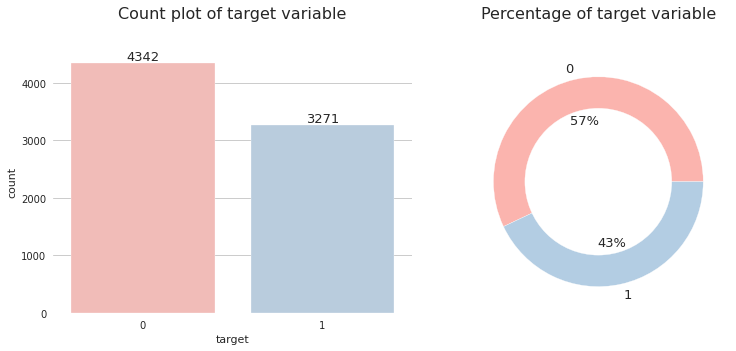

In [5]:
plot_distribution(df=train_data, col='target')

## Exploratory Data Analysis
### Check for missing data

In [0]:
def check_missing(df):
    # Summarization of mising data in the data frame
    missing_df = pd.DataFrame(df.isnull().sum(), columns=['num_missing'])
    missing_df['percent_missing'] = missing_df['num_missing']/len(df)
    return missing_df

In [7]:
# Percentage of missing data in training set
check_missing(train_data)

,num_missing,percent_missing
id,0,0.000000
keyword,61,0.008013
location,2533,0.332720
text,0,0.000000
target,0,0.000000


In [8]:
# Percentage of missing data in testing set
check_missing(test_data)

,num_missing,percent_missing
id,0,0.000000
keyword,26,0.007968
location,1105,0.338645
text,0,0.000000


In [9]:
print('Number of unique keyword: ', len(set(train_data.keyword)))
print('Number of unique location: ', len(set(train_data.location)))

Number of unique keyword:  222
Number of unique location:  3342


Only `keyword` and `location` columns have missing data:
- The **keyword** data is a substring of the text data, there are 222 unique keywords
- The **location** data is very dirty, and over 33% of them is missing in both training and testing data

### Check for duplicated data 
110 texts in the training data are **duplicated**, maybe because of the retweet?

In [10]:
train_data.text.duplicated().sum()

110

In [11]:
duplicated_train = train_data[train_data.text.duplicated()]
duplicated_train 

,id,keyword,location,text,target
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
119,172,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
164,238,airplane%20accident,NaN,Experts in France begin examining airplane deb...,1
624,898,bioterrorism,NaN,To fight bioterrorism sir.,0
...,...,...,...,...,...
7600,10855,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [12]:
not_uniq_target = duplicated_train  \
                   .groupby('text') \
                   .apply(lambda x: len(x.target.unique())!=1)

not_uniq_target = pd.DataFrame(not_uniq_target[not_uniq_target.values], 
                               columns=['not_uniq_target'])
print('{} text data has non-unique target values'.format(len(not_uniq_target)))

9 text data has non-unique target values


The problem is **9 of these duplicated text have different sentiment (target value)**, which will be harmful for our model training. We will label them manually since it is only very few of them. 

In [13]:
not_uniq_target

,not_uniq_target
text,
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,True
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption,True
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,True
CLEARED:incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,True
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam,True
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife,True
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.',True
To fight bioterrorism sir.,True
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time,True


I think none of these is a real disaster message after reading them, thus they should be **labeled as 0**.

In [0]:
new_target = dict(zip(not_uniq_target.index, np.zeros(9, dtype='int')))
train_data['target'] = train_data.apply(lambda x: new_target[x.text] 
                                        if x.text in new_target.keys() 
                                        else x.target, axis=1)

Now we have fixed the duplicated texts with different target value. let's check the distribution of target variable one more time.

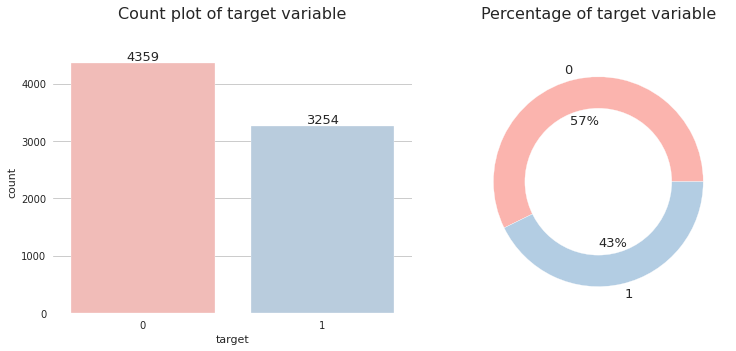

In [15]:
plot_distribution(df=train_data, col='target')

### Top keywords

In [0]:
def plot_top_occur(col, top, df, label):
    
    value_count = dict(df[col].value_counts().head(top))
    plt.figure(figsize=(13, 5))
    ax = sns.countplot(
        x=col, data=df, 
        order=sorted(value_count, key=value_count.get, reverse=True),
        palette='Set3')

    ax.set_xticklabels(ax.get_xticklabels(), 
                       horizontalalignment='right',
                       fontsize=16,
                       rotation=45)
    ax.set_xlabel('')

    ax.set_title('Top {} {} in {} Tweets'.format(top, col, label), fontsize=18)
    plt.show()

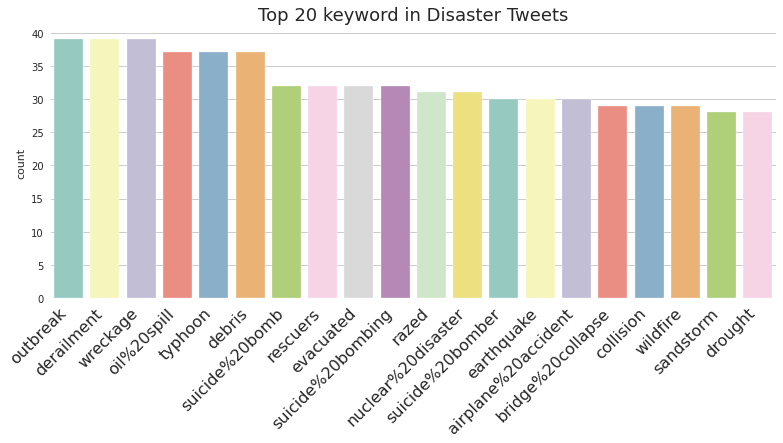

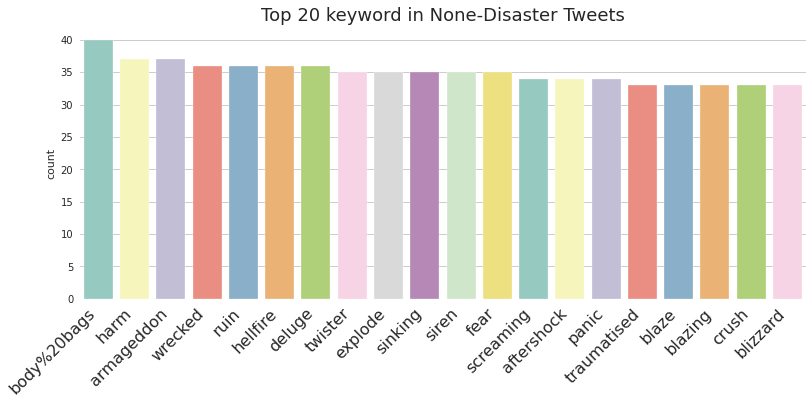

In [19]:
# Disaster Tweets
plot_top_occur(col='keyword', top=20, label='Disaster', 
               df=train_data[train_data.target==1])
# None-Disaster Tweets
plot_top_occur(col='keyword', top=20, label='None-Disaster', 
               df=train_data[train_data.target==0])

Note the countplots above are based on the **number of occurrences** (or frequency). The most frequently occurred keywords are quite different between disaster and non-disaster tweets. Next, let's check the **disaster rate** of the keywords, which represents the probability of being a disaster tweet given a certain keyword.

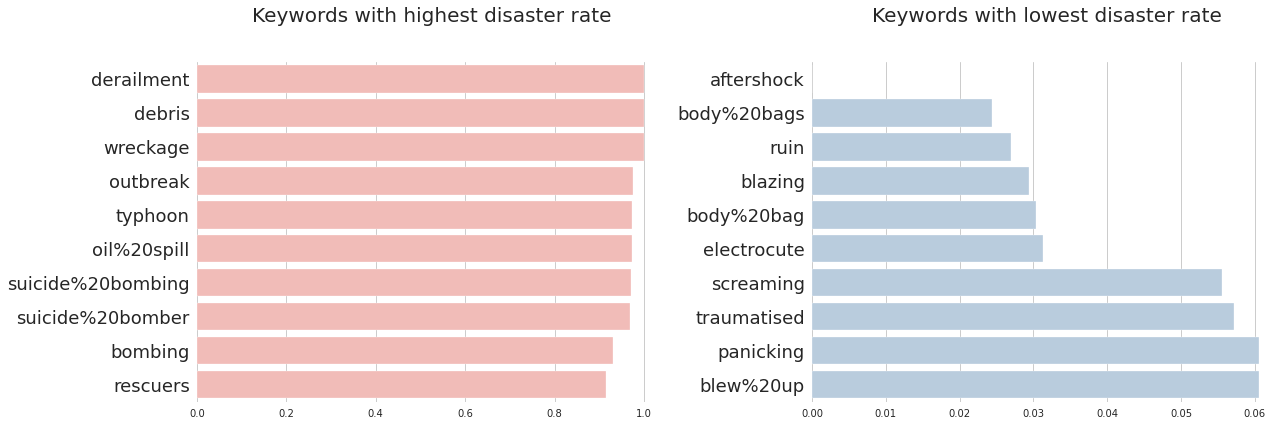

In [20]:
top_key = train_data.groupby('keyword') \
                    .mean()['target'] \
                    .sort_values(ascending=False).head(10)

bottom_key = train_data.groupby('keyword') \
                       .mean()['target'] \
                       .sort_values().head(10)                       

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
fig.subplots_adjust(hspace = .5, wspace=.01)
title_fontsize = 20 
y_fontsize = 18
axs = axs.ravel()

sns.barplot(top_key, top_key.index, color=Pastel1_7.hex_colors[0], ax=axs[0])
axs[0].set_title('Keywords with highest disaster rate',
                 y=1.1, fontsize=title_fontsize)
axs[0].set_yticklabels(axs[0].get_yticklabels(), 
                       fontsize=y_fontsize)
axs[0].set_ylabel('')
axs[0].set_xlabel('')

sns.barplot(bottom_key, bottom_key.index, color=Pastel1_7.hex_colors[1], ax=axs[1])
axs[1].set_title('Keywords with lowest disaster rate',
                 y=1.1, fontsize=title_fontsize)
axs[1].set_yticklabels(axs[1].get_yticklabels(), 
                       fontsize=y_fontsize)
axs[1].set_ylabel('')
axs[1].set_xlabel('')

plt.tight_layout()
plt.show()

### Top Locations

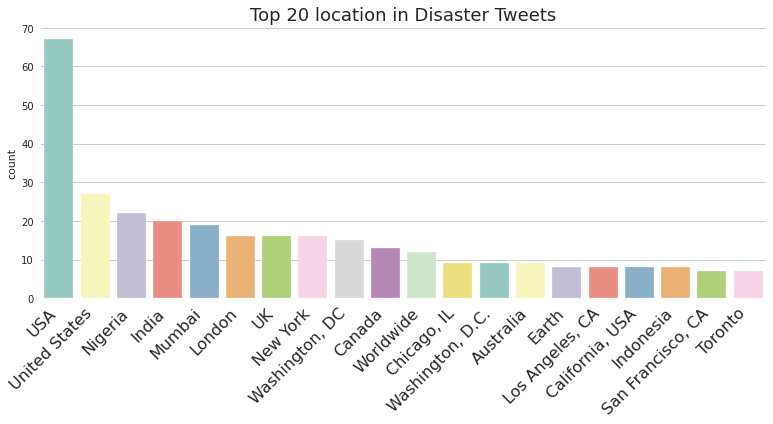

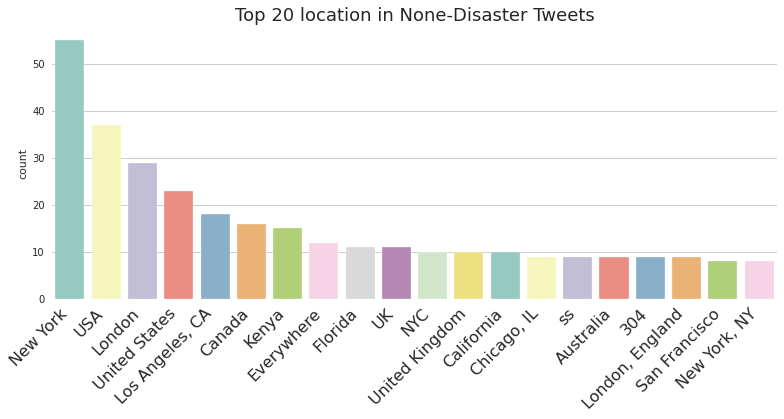

In [21]:
### Disaster Tweets 
plot_top_occur(col='location', top=20, label='Disaster', 
               df=train_data[train_data.target==1])
# None-Disaster Tweets
plot_top_occur(col='location', top=20, label='None-Disaster',
               df=train_data[train_data.target==0])

- **USA** and **United States** both show up here, but are actually the same
- There are a lot of no sense words (especially in none-disaster tweets) like Everywhere, Earth, Worldwide, 304, ss, etc...

A lot of the data cleaning need to be done.

### Clean Location Data

We have seen that the location data is very dirty. Some of them refer to the same location but in different words (e.g. 'us', 'usa', 'america', 'united states'), and some of them do not make sense at all (e.g. 'Happily Married with 2 kids').

 We need to do some basic cleaning first before performing any further analysis.

In [0]:
# City level mapping
lower_mapping = {'ny': ['new york', 'ny', 'nyc'],
                 'sf': ['san francisco', 'bay area'],
                 'seattle': ['seattle'],
                 'dc': ['dc', 'washington dc'],
                 'toronto':['toronto'],
                 'london': ['london'],
                 'mumbai': ['mumbai'],
                 'chicago': ['chicago'],
                 'nashville': ['nashville'],
                 'la': ['los angeles'],
                 'denver': ['denver'],
                 'nigeria': ['nigeria']}

# Country & State level mapping
upper_mapping = {'us': ['us', 'usa', 'america', 'united states', 
                        'united states of america'],
                 'uk': ['united kingdom', 'uk', 'britain', 'england'],
                 'world': ['world', 'worldwide', 'global', 
                           'nowhere everywhere', 
                           'planet earth', 'the universe'],
                 'tx': ['texas', 'tx'],
                 'ca': ['california usa', 'ca', 'north california', 
                        'south california']}

def match_lower(loc):
    for key, places in lower_mapping.items():
        if any([loc.find(place) != -1 for place in places]):
            return key
        else:
            continue
    return loc
                        
def match_upper(loc):
    for key, places in upper_mapping.items():
        if any([place.find(loc) != -1 for place in places]):
            return key
        else:
            continue
    return loc

In [0]:
# Fill the missing location data with 'none'
train_data.location.fillna('none', inplace=True)

# Create a new column for clean location:
# Convert all characters to lower case
# Remove numbers and puntuations

train_data['clean_location'] = train_data['location'] \
    .apply(lambda x: re.sub('[^a-zA-Z\s]+', '', x.lower()))
train_data['clean_location'] = train_data['clean_location']\
    .apply(lambda x: 'none' if not x.strip() else x.strip())
train_data['clean_location'].fillna('none', inplace=True)
train_data['clean_location'] = train_data['clean_location'].apply(match_lower)
train_data['clean_location'] = train_data['clean_location'].apply(match_upper)

In [23]:
train_data[['location', 'clean_location']].iloc[50:60]

,location,clean_location
50,"Sheffield Township, Ohio",sheffield township ohio
51,India,india
52,Barbados,barbados
53,Anaheim,anaheim
54,Abuja,abuja
55,USA,us
56,South Africa,south africa
57,"Sao Paulo, Brazil",sao paulo brazil
58,hollywoodland,hollywoodland
59,"Edmonton, Alberta - Treaty 6",edmonton alberta treaty


Now let's check the frequency of the clean_location.

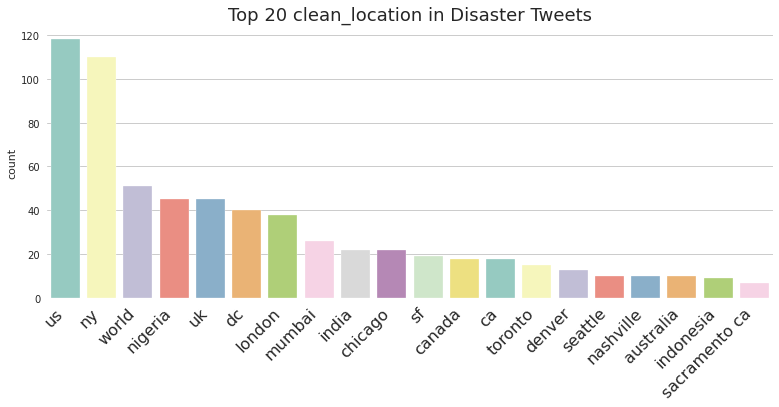

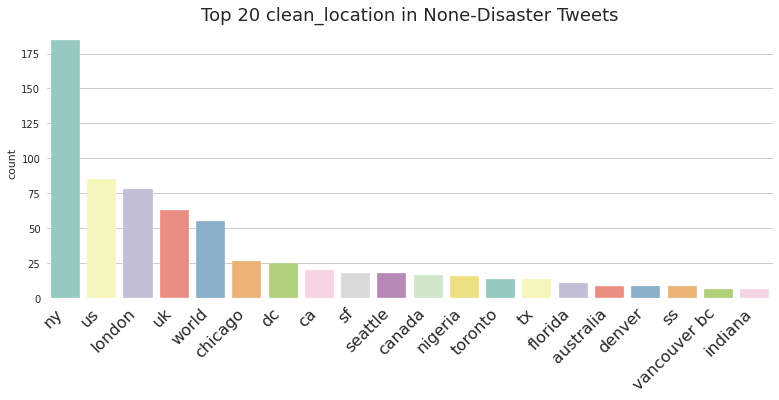

In [30]:
### Disaster Tweets 
plot_top_occur(col='clean_location', top=20, label='Disaster', 
               df=train_data[(train_data.target==1) &
                             (train_data.clean_location!='none')])
# None-Disaster Tweets
plot_top_occur(col='clean_location', top=20, label='None-Disaster',
               df=train_data[(train_data.target==0) &
                             (train_data.clean_location!='none')])

It makes more sense now! Let's check the disaster rate of the clean_location, just like what we did with the keyword data.

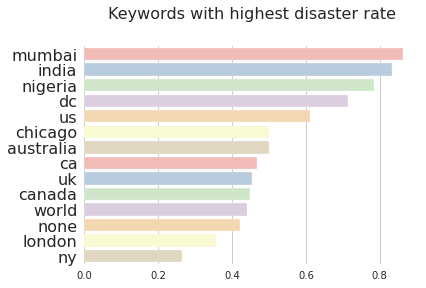

In [37]:
# Only consider the most frequently occurred locations (top 20) 
top = 20
raw_loc = train_data.location.value_counts().head(top)
top_loc_df = train_data[train_data.location.isin(raw_loc.index)]
top_loc = top_loc_df.groupby('clean_location') \
                    .mean()['target'] \
                    .sort_values(ascending=False)
plt.plot(figsize=(20, 20))
ax = sns.barplot(top_loc, top_loc.index, palette=Pastel1_7.hex_colors)
ax.set_title('Keywords with highest disaster rate',
              y=1.1, fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
ax.set_ylabel('')
ax.set_xlabel('')
plt.show()

Mumbai, India and Nigeria have the highest disaster rate.

Next we will extract some meta-information from the text data. To do that, we need to clean the text data first.

### Meta information
- Number of characters
- Number of words
- Number of unique words
- Number of URLs
- Number of punctuations
- Number of stopwords
- Number of upper case characters
- Ratio of upper case characters

In [0]:
def add_clean_text(df):
    
    # Convert Special characters to ASCII
    df['clean_text'] = df['text'].apply(lambda x: 
        x.encode("ascii", errors="ignore").decode())
    # Remove URLs
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('http\S*', '', x))
    # Deal with special meaning characters 
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('&gt;', '', x))
    # Remove extra space 
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub('(\s\s*|\n)', ' ', x))
    df['clean_text'] = df['clean_text'].apply(lambda x: x.strip())
    return df

#### Example:

In [0]:
row = 124
print('Original Text:\n', train_data['text'].iloc[row])
print('Clean Text:\n', train_data['clean_text'].iloc[row])

Original Text:
 &gt;&gt; $15 Aftershock : Protect Yourself and Profit in the Next Global Financial... ##book http://t.co/f6ntUc734Z
@esquireattire
Clean Text:
 $15 Aftershock : Protect Yourself and Profit in the Next Global Financial... ##book @esquireattire


In [0]:
row = 38
print('Original Text:\n', train_data['text'].iloc[row])
print('Clean Text:\n', train_data['clean_text'].iloc[row])

Original Text:
 Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J
Clean Text:
 Barbados #Bridgetown JAMAICA Two cars set ablaze: SANTA CRUZ Head of the St Elizabeth Police Superintende...


In [39]:
train_data = add_clean_text(train_data)
train_data.head()

,id,keyword,location,text,target,clean_location,clean_text
0,1,NaN,none,Our Deeds are the Reason of this #earthquake M...,1,none,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,none,Forest fire near La Ronge Sask. Canada,1,none,Forest fire near La Ronge Sask. Canada
2,5,NaN,none,All residents asked to 'shelter in place' are ...,1,none,All residents asked to 'shelter in place' are ...
3,6,NaN,none,"13,000 people receive #wildfires evacuation or...",1,none,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,none,Just got sent this photo from Ruby #Alaska as ...,1,none,Just got sent this photo from Ruby #Alaska as ...


In [0]:
all_disaster_text = train_data[train_data.target==1].text.str.cat()
none_disaster_text = train_data[train_data.target==0].text.str.cat()
all_disaster_clean_text = train_data[train_data.target==1].clean_text.str.cat()
non_disaster_clean_text = train_data[train_data.target==0].clean_text.str.cat()

In [0]:
def plot_top_occur_ptn(all_text, pattern, top, label):
    
    value_count = dict(Counter([w.lower() for w in 
                                re.findall(pattern, all_text) 
                                if w.lower() not in all_stopwords]))

    ordered_count = {key: value_count[key] 
                     for key in sorted(value_count, 
                                       key=value_count.get, 
                                       reverse=True)[:top]}
    
    width = 0.7*top if top >= 10 else 6
    plt.figure(figsize=(width, 4.5))
    ax = sns.barplot(x=[char for char in list(ordered_count.keys())], 
                     y=list(ordered_count.values()),  
                     palette='Set3')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
    ax.set_title('Top {} {} in {} Tweets'.format(top, label[0], label[1]), fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), 
                       horizontalalignment='right',
                       fontsize=15,
                       rotation=45)
    plt.show()

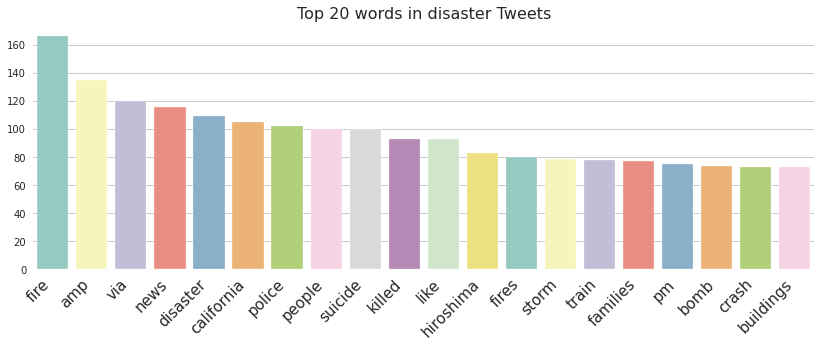

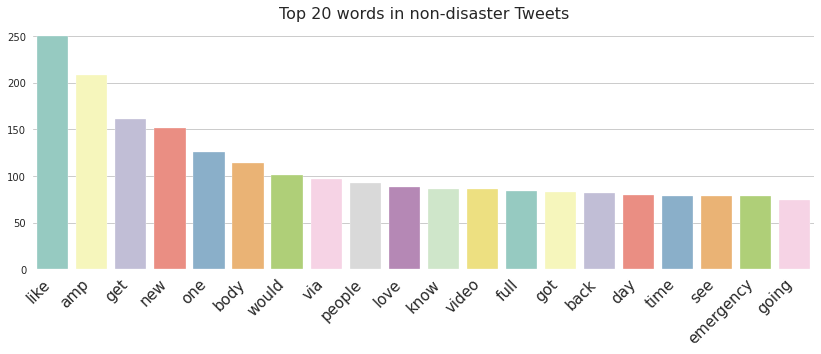

In [44]:
plot_top_occur_ptn(all_disaster_clean_text, '[a-zA-Z]+', top=20, label=('words','disaster'))
plot_top_occur_ptn(non_disaster_clean_text, '[a-zA-Z]+', top=20, label=('words','non-disaster'))

We can also use Word Cloud to visualize the frequency of words.

In [0]:
def plot_word_cloud(text):
  # Create and generate a word cloud image:
  wordcloud = WordCloud(background_color="white",
                        stopwords=all_stopwords,
                        max_words=500).generate(text)

  # Display the generated image:
  plt.figure(figsize=(10, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

 Word cloud for Disaster Tweets: 


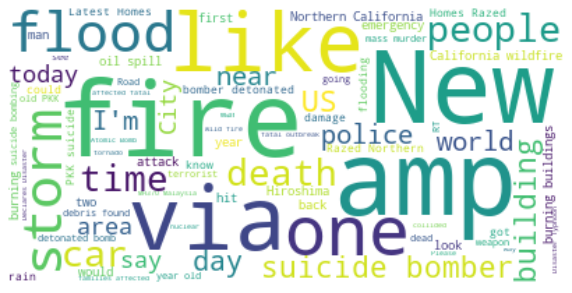


 Word cloud for Non-Disaster Tweets: 


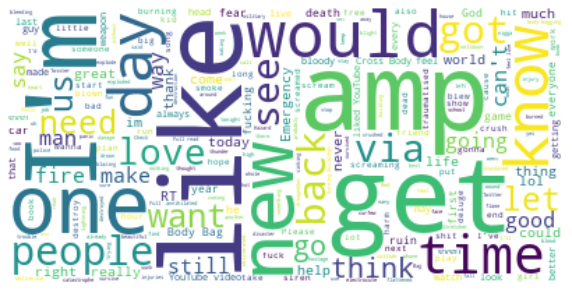

In [71]:
print('\033[1m Word cloud for Disaster Tweets: \033[0m')
plot_word_cloud(all_disaster_clean_text)
print()
print('\033[1m Word cloud for Non-Disaster Tweets: \033[0m')
plot_word_cloud(non_disaster_clean_text)

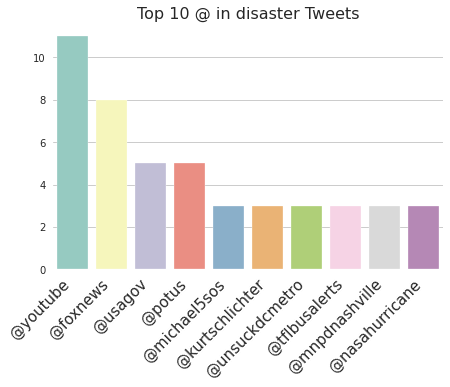

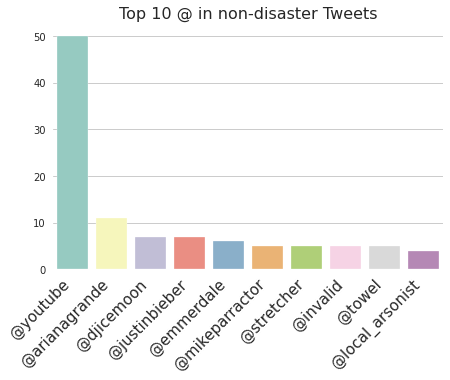

In [45]:
plot_top_occur_ptn(all_disaster_text, '@\S+', top=10, label=('@','disaster'))
plot_top_occur_ptn(none_disaster_text, '@\S+', top=10, label=('@','non-disaster'))

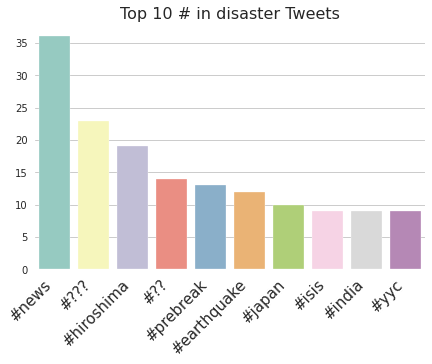

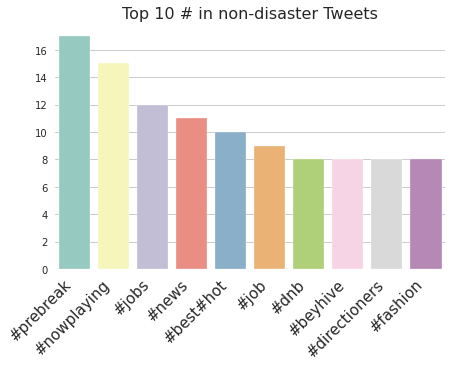

In [46]:
plot_top_occur_ptn(all_disaster_text, '#\S+', top=10, label=('#','disaster'))
plot_top_occur_ptn(none_disaster_text, '#\S+', top=10, label=('#','non-disaster'))

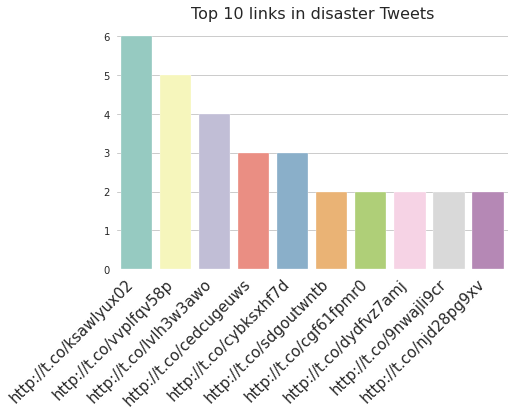

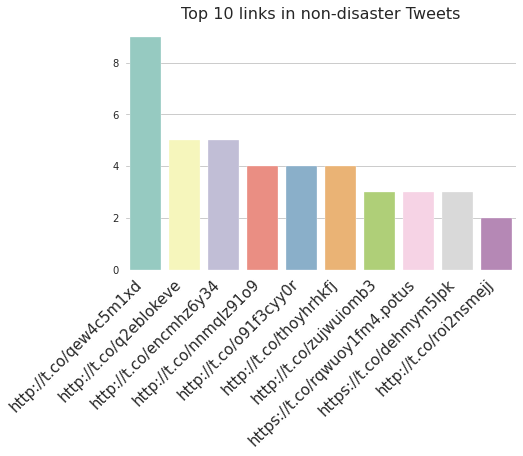

In [47]:
plot_top_occur_ptn(all_disaster_text, 'http\S*', top=10, label=('links','disaster'))
plot_top_occur_ptn(none_disaster_text, 'http\S*', top=10, label=('links','non-disaster'))

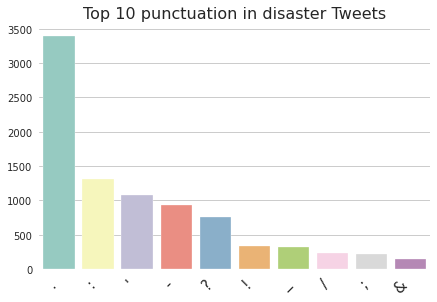

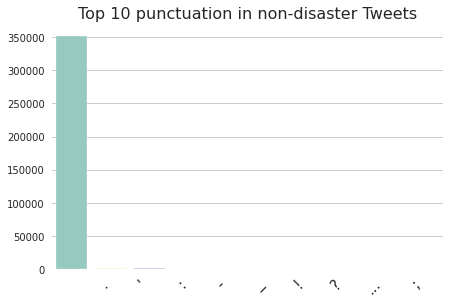

In [48]:
plot_top_occur_ptn(all_disaster_clean_text, '[^a-zA-Z0-9#@\s]', top=10, label=('punctuation','disaster'))
plot_top_occur_ptn(non_disaster_clean_text, '[^a-zA-Z0-9#@\s]*', top=10, label=('punctuation','non-disaster'))

In [0]:
def calc_meta(data):
    
    df = data.copy()
    df['num_urls'] = df['text'].apply(lambda x: len(re.findall('http\S*', x)))
    df['num_ats'] = df['clean_text'].apply(lambda x: len(re.findall('@\S+', x)))
    df['num_hashtags'] = df['clean_text'].apply(lambda x: len(re.findall('#\S+', x)))
    df['num_puncs'] = df['clean_text'].apply(lambda x: len(re.findall('[^a-zA-Z0-9#@\s]', x)))
    df['num_chars'] = df['clean_text'].str.len()
    df['num_upper_case'] = df['clean_text'].apply(lambda x: len([word for word in x if word.isupper()]))
    df['upper_case_ratio'] = df['num_upper_case']/df['num_chars']
    df['num_words'] = df['clean_text'].apply(lambda x: len(x.split()))
    df['num_stop_words'] = df['clean_text'].apply(
        lambda x: len([word for word in x.split() if word in all_stopwords]))

    return df

In [50]:
cols = ['num_chars', 'num_upper_case',
        'upper_case_ratio', 'num_words', 
        'num_stop_words', 'num_urls', 
        'num_ats', 'num_hashtags',
        'num_puncs']
meta_df = calc_meta(train_data)
meta_df[cols].describe()

,num_chars,num_upper_case,upper_case_ratio,num_words,num_stop_words,num_urls,num_ats,num_hashtags,num_puncs
count,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,86.205438,7.209904,0.089624,14.272035,3.750427,0.620255,0.357415,0.443321,2.899514
std,32.547162,9.545426,0.120277,5.852020,3.197514,0.664104,0.713439,1.093788,3.027335
min,5.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,61.000000,2.000000,0.028571,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,88.000000,4.000000,0.054264,14.000000,3.000000,1.000000,0.000000,0.000000,2.000000
75%,113.000000,9.000000,0.107143,18.000000,6.000000,1.000000,1.000000,0.000000,4.000000
max,157.000000,118.000000,1.000000,31.000000,18.000000,4.000000,8.000000,13.000000,58.000000


In [0]:
def plot_by_target(plot_type, df):
    
    VALID = {'box', 'dist'}
    if plot_type not in VALID:
        raise ValueError("results: plot_type must be one of %r." % VALID)
    
    def _box_plot(y, ax):
        return sns.boxplot(x="target", y=y, data=df, ax=ax)

    def _dist_plot(col, ax):
        kde = False if col in ['num_ats', 'num_hashtags'] else True
        sns.distplot(df[df['target']==1][col], 
                          ax=ax, kde=kde, label='1')
        sns.distplot(df[df['target']==0][col], 
                          ax=ax, kde=kde, label='0')
        ax.legend(ncol=1, fontsize=15)
            
    FUNCTION_MAP = {'box': _box_plot, 'dist': _dist_plot}
    func = FUNCTION_MAP[plot_type]
    FONTDICT = {'fontsize': 15}
    
    num_rows = int(np.ceil(len(cols)/3))
    
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, 4*num_rows))
    fig.subplots_adjust(hspace = .5, wspace=.01)
    axs = axs.ravel()
    for ax in axs[len(cols):]:
        ax.set_visible(False)

    for i in range(len(cols)):
        func(cols[i], ax=axs[i])
        axs[i].set_xlabel('')
        axs[i].set_title(cols[i], fontsize=15)
 
    plt.tight_layout()
    plt.show() 

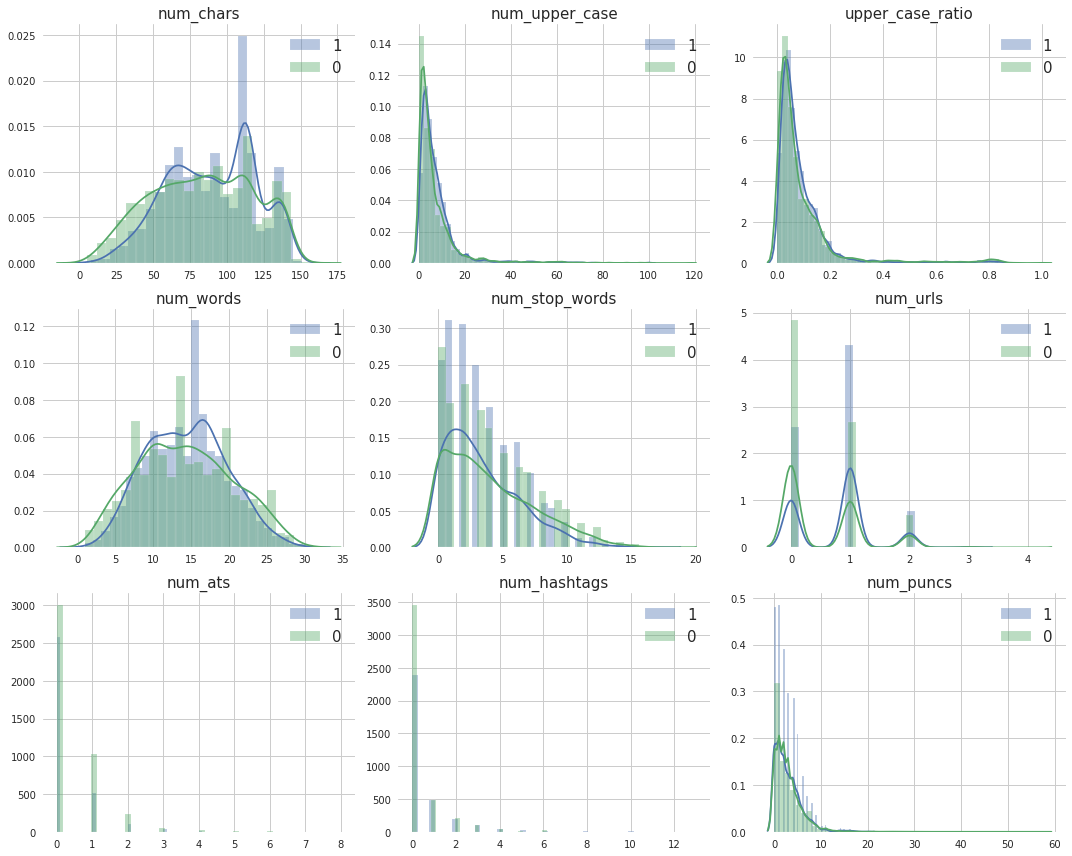

In [52]:
plot_by_target('dist', meta_df)

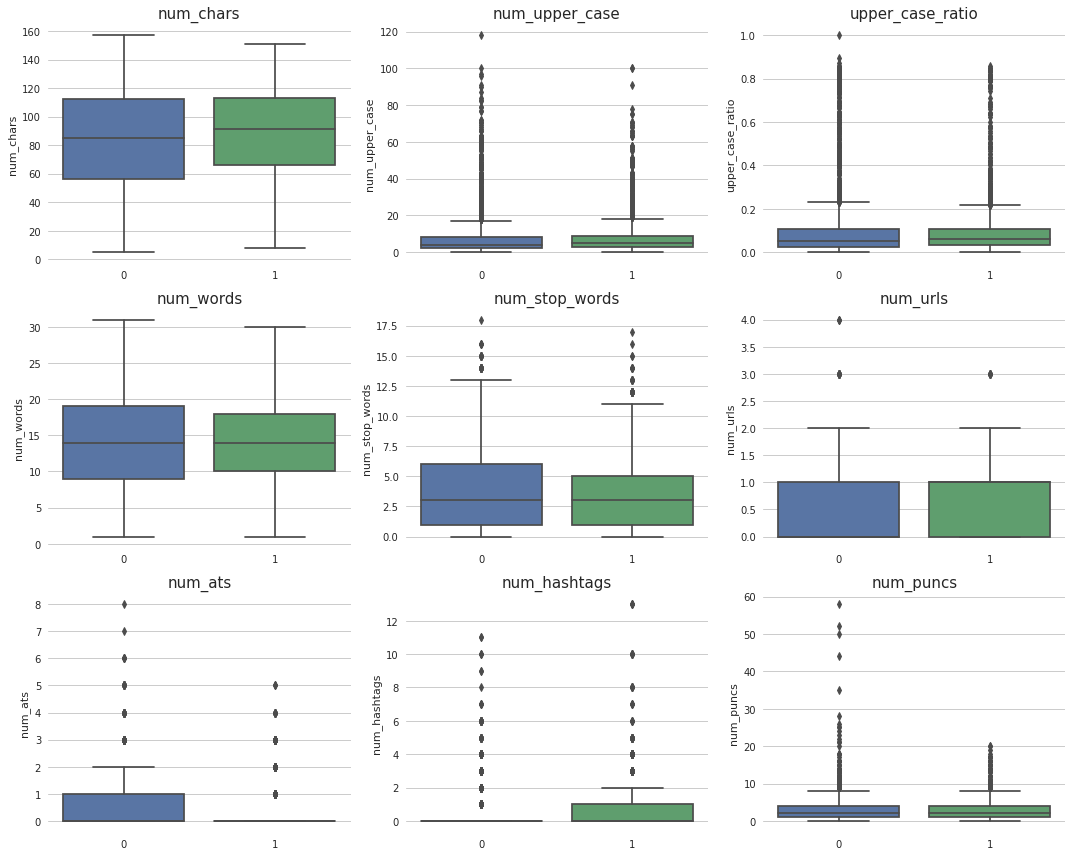

In [53]:
plot_by_target('box', meta_df)

**Finding from distribution of meta data**
- Disaster tweets have more `characters`
- Disaster tweets have more `#` and `punctuations`
- Disaster tweets have more `uppercase characters` and `upper_case_ratio`
- Non-disaster tweets have more `URL` and `@`s
- Non-disaster tweets have more `stop words` (meaningless words)

Okay, now we are done with a complete EDA for the text data. 